# Chapter 7: Clustering in R

In the present notebook (with R kernel), we will learn how the two most famous clustering techniques work. Those are:

* K-means
* Gaussian Mixture Modeling (GMM)

We will build those methods from scratch and, in the process, learn about the important Expectation-Maximization (EM) algorithm. We will again use the Iris benchmark dataset for illustration purposes.

<img src="figs_notebook/header_clustering.jpg">


## 1. Clustering from scratch

### 1.1. Iris dataset

_Iris flower data set_: "_This is perhaps the best known database to be found in the pattern recognition literature. Fisher's paper is a classic in the field and is referenced frequently to this day (See Duda & Hart, for example). The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. One class is linearly separable from the other 2; the latter are NOT linearly separable from each other_" (UCI Machine Learning Repository).

The dataset is already included in R as `iris`. It is plotted below by feature pair, with the different classes represented by colors. In the unsupervised case that follows, the models will not have access to the classes.

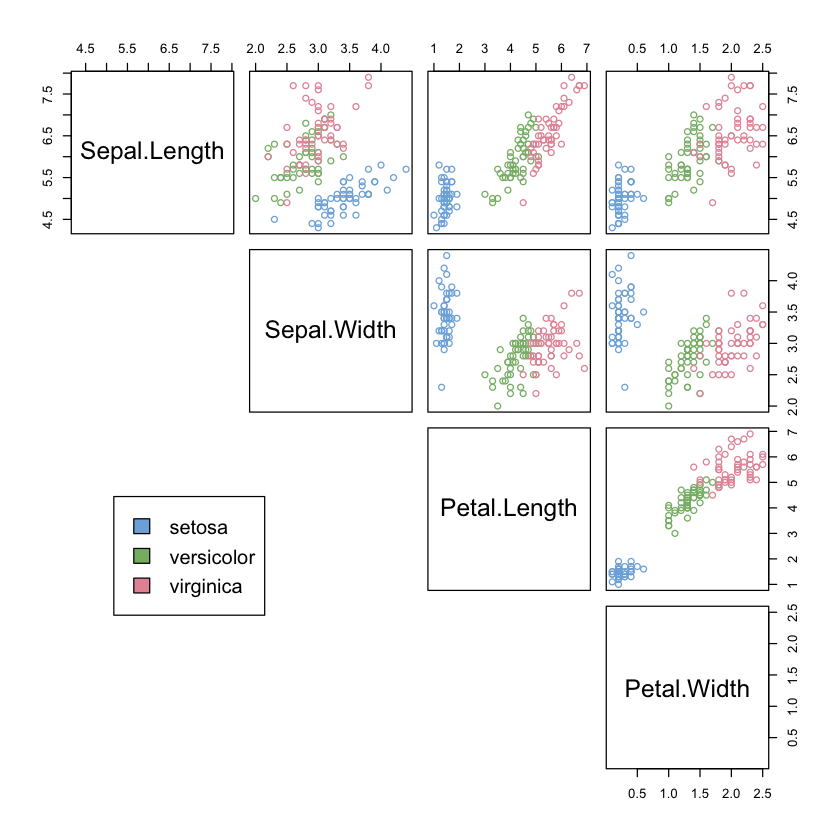

In [1]:
X <- iris[,1:4]
y <- iris[,5]

y_col <- c('#7DB0DD', '#86B875', '#E495A5')

pairs(X, lower.panel = NULL, col = y_col[y])
par(xpd = T)
legend(x = 0.1, y = 0.4, legend = as.character(levels(y)), fill = y_col)

### 1.2. K-means technique

We learn from the excellent review ‘Data clustering: 50 years beyond K-means’ (Jain, 2010) that the development of clustering methods has been an interdisciplinary endeavour with a multitude of contributions from taxonomists, biologists, psychologists, statisticians, engineers, etc., and that the term ‘data clustering’ first appeared in the title of a 1954 article dealing with anthropological data. Of all existing clustering algorithms, K-means is the most popular and simplest. It has a rich and diverse history as it was independently discovered in different scientific fields between 1956 and 1967.

**EXERCISES 1-3:** Fill in the `kmeans_manual` function. The goal of K means is to find a partition between `k` clusters such that the squared error between empirical mean and points in a cluster is minimized over all k clusters. This is a 3-step procedure:

1. Initialise the centroids taking `k` random data points from `X`. Use `X[ind,]` with `ind = sample(x, n_samples)` where the function samples `n_samples` from the index range `1:x`. _Hint:_ to get the total number of data samples, use `nrow(X)`.
2. Define a simplified version of E step: calculate the sum (`sum()`) of squared distances between centroid and data points. _Hints:_ we here loop over centroid `c` and then over sample `i`, so you just need to use `centroid[c,]` and `X[i,]`.
3. Define a simplified version of M step: update the centroid by the mean of the samples in each cluster. Use the R `apply` function for it. _Hints:_ `apply` works as follows `apply(x, ij, function)`. Here the function is simply `mean`. `ij = 1` for application on rows, `ij = 2` for application on columns. You will need to take the mean from all samples within one specific cluster, which means samples with index verifying `cluster == c`.

In [2]:
kmeans_manual <- function(X, k){
  p <- ncol(X)  # number of parameters
  n <- nrow(X)  # number of observations
  Delta <- 1; iter <- 0; itermax <- 30
  while(Delta > 1e-4 && iter <= itermax){

    # initiation
    if(iter == 0){
      # YOUR CODE HERE
#      centroid <- ?
        
      # SOLUTION
      centroid <- X[sample(nrow(X), k),]

      centroid_mem <- centroid
    }
    
    # equivalent to E-step
    # YOUR CODE HERE
#    d <- sapply(1:k, function(c) sapply(1:n, function(i) ? ))
                                        
    # SOLUTION
    d <- sapply(1:k, function(c) sapply(1:n, function(i) sum((centroid[c,] - X[i,])^2) ))
    cluster <- apply(d, 1, which.min)
    
    # equivalent to M-step
    # YOUR CODE HERE
#    centroid <- t(sapply(1:k, function(c) apply( ? )))
                         
    # SOLUTION
    centroid <- t(sapply(1:k, function(c) apply(X[cluster == c,], 2, mean)))
    
    Delta <- sum((centroid - centroid_mem)^2)
    iter <- iter + 1; centroid_mem <- centroid
  }
  return(list(centroid = centroid, cluster = cluster))
}

**EXERCISE 4:** Run your `kmeans_manual` for a proper number of clusters `k`. Plot the result with `pairs(X, lower.panel = NULL, col = ?)` and use the function `table(y_obs, y_pred)` to compare the results to the observations.

            
y             1  2  3
  setosa      0 50  0
  versicolor  3  0 47
  virginica  36  0 14

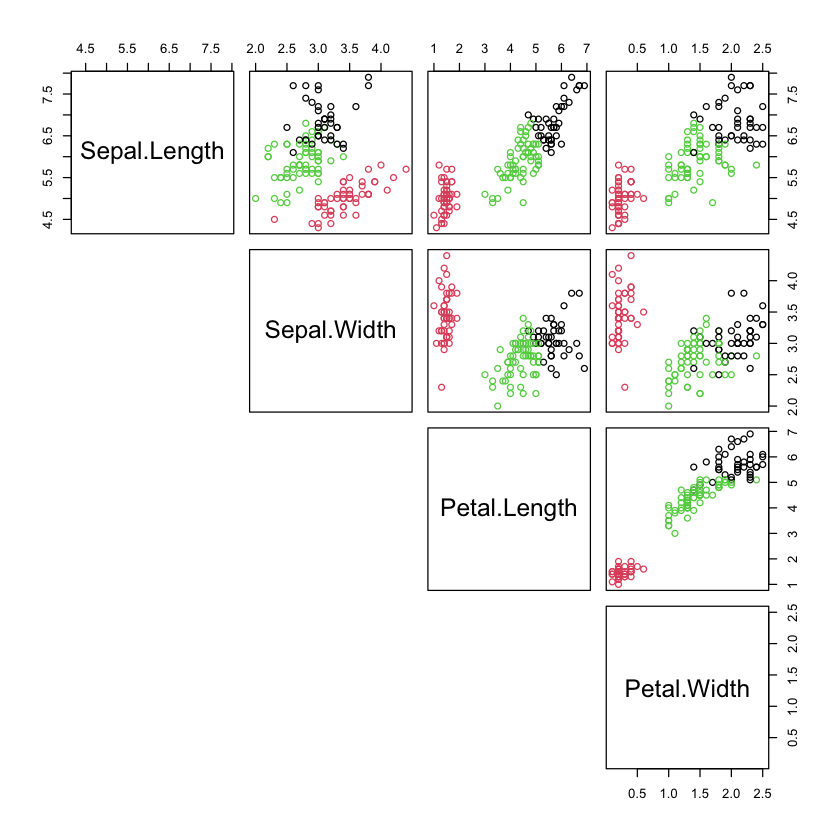

In [3]:
# SOLUTION
km1 <- kmeans_manual(X, 3)
pairs(X, lower.panel = NULL, col = km1$cluster)
table(y, km1$cluster)

**EXERCISE 5:** Then, run the built-in function `result = kmeans(X, k)`. Again, plot the result and print the confusion matrix. _Hint:_ Check the output of `kmeans` and find the component that you need using `result$component`.

            
y             1  2  3
  setosa      0 50  0
  versicolor 48  0  2
  virginica  14  0 36

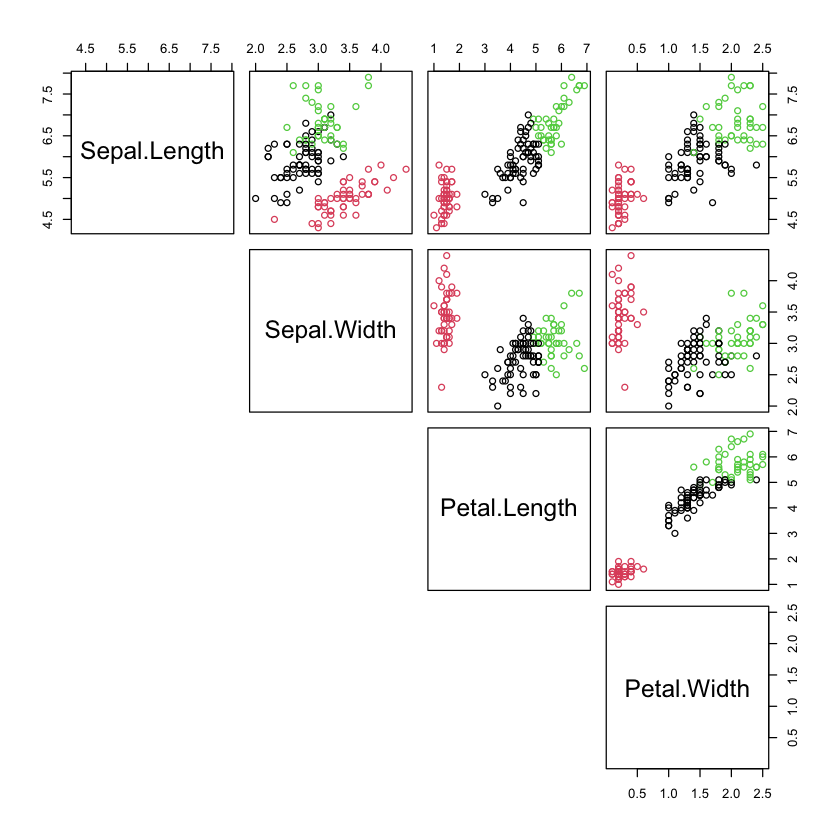

In [5]:
# SOLUTION
km2 <- kmeans(X, 3)
pairs(X, lower.panel = NULL, col = km2$cluster)
table(y, km2$cluster)

**EXERCISE 4:** Are the results obtained similar? How should you interpret the results of the confusion tables? e.g. does it matter if we don't get the maximum counts on the diagonal? You may rereun the previous cells several times to observe what happens (note that clustering cannot assure to reach the global optimum. Running it several times may give you different performances).

YOUR ANSWER HERE


SOLUTION

Yes the results are similar, only our function is slower than the built-in function. If the method clusters correctly, each column (i.e. cluster) should contain mostly one class. The diagonal is meaningless here since each cluster can be attributed to any class, with no order preference (since the unsupervised technique has no access to the labels).

The following animation is based on the proposed R code but with the radius of the cluster spherical decision boundary plotted, using the panel option of the `pairs()` function (full code not shown). If you look again at the code we defined, in particular `cluster <- apply(d, 1, which.min)`, you can see that each sample is attributed to the cluster for which the distance to the cluster centroid is the smallest (compared to the distance to the other centroids).

<img src="figs_notebook/fig_kmeans_anim.gif">


### 1.3. Gaussian mixture model (GMM)

The mixture of Gaussians (Gaussian Mixture Model or GMM) is the most widely used mixture model. GMM can be described as a soft version of K-means with Gaussian density.

We will now define a GMM from scratch. You will notice that the structure of the algorithm is very similar to the one of the K-means algorithm. Again, it will correspond to parameter initialisation, E-step, and M-step.

First, we give you the following functions to define the multivariate normal distribution.

In [6]:
mvnorm.cov.inv <- function(Sigma) {
  # Eigendecomposition of covariance matrix
  E <- eigen(Sigma)
  Lambda.inv <- diag(E$values^-1)   # diagonal matrix
  Q <- E$vectors
  return(Q %*% Lambda.inv %*% t(Q))
}

#multivariate Gaussian pdf
mvn.pdf.i <- function(xi, mu, Sigma)
  1/sqrt( (2*pi)^length(xi) * det(Sigma) ) * 
  exp(-(1/2) * t(xi - mu) %*% mvnorm.cov.inv(Sigma) 
  %*% (xi - mu)  )

mvn.pdf <- function(X, mu, Sigma)
  apply(X, 1, function(xi) mvn.pdf.i(as.numeric(xi), mu, Sigma))

**EXERCISES 5-6:** Fill in the `gmm_manual` function. This is again a 3-step procedure (initialisation, E-M steps):

5. Initialise the mean of the Gaussian clusters `mu` as the K-means clusters obtained in the previous section.
6. Define the E step: calculate `mvn.c` by filling the PDF function `mvn.pdf()`. _Hint:_ check the previous cell to understand what `mvn.pdf` does and which parameters it calls.

For convenience, the M-step is already done for you.

In [7]:
gmm_manual <- function(X, k){
  p <- ncol(X)  # number of parameters
  n <- nrow(X)  # number of observations
  Delta <- 1; iter <- 0; itermax <- 30

  while(Delta > 1e-4 && iter <= itermax){
    # initiation
    if(iter == 0){
      # YOUR CODE HERE
#      km.init <- ?
#      mu <- ?; mu_mem <- mu


      # SOLUTION
      km.init <- kmeans_manual(X, k)
      mu <- km.init$centroid; mu_mem <- mu


      w <- sapply(1:k, function(i) length(which(km.init$cluster == i)))
      w <- w/sum(w)
      cov <- array(dim = c(p, p, k))
      for(i in 1:p) for(j in 1:p) for(c in 1:k) cov[i, j, c] <- 1/n *
        sum((X[km.init$cluster == c, i] - mu[c, i]) * 
        (X[km.init$cluster == c, j] - mu[c, j]))
    }
    
    # E-step
    # YOUR CODE HERE
#    mvn.c <- sapply(1:k, function(c) mvn.pdf(?, ?, cov[,, c]))
    
    # SOLUTION
    mvn.c <- sapply(1:k, function(c) mvn.pdf(X, mu[c,], cov[,, c]))
                    

    r_ic <- t(w*t(mvn.c)) / rowSums(t(w*t(mvn.c)))
    
    # M-step
    n_c <- colSums(r_ic)
    w <- n_c/sum(n_c)
    mu <- t(sapply(1:k, function(c) 1/n_c[c] * colSums(r_ic[, c] * X)))
    for(i in 1:p) for(j in 1:p) for(c in 1:k) cov[i, j, c] <- 1/n_c[c] *
      sum(r_ic[, c] * (X[, i] - mu[c, i]) * r_ic[, c] * (X[, j] - mu[c, j]))

    Delta <- sum((mu - mu_mem)^2)
    iter <- iter + 1; mu_mem <- mu
  }
  return(list(softcluster = r_ic, cluster = apply(r_ic, 1, which.max)))
}


**EXERCISE 7:** Run your `gmm_manual` for a proper number of clusters `k`. Plot the result with `pairs(X, lower.panel = NULL, col = ?)` and use the function `table(y_obs, y_pred)` to compare the results to the observations. Consider rerunning the model several times until you think that the global optimum has been reached.

            
y             1  2  3
  setosa      0 50  0
  versicolor  5  0 45
  virginica  50  0  0

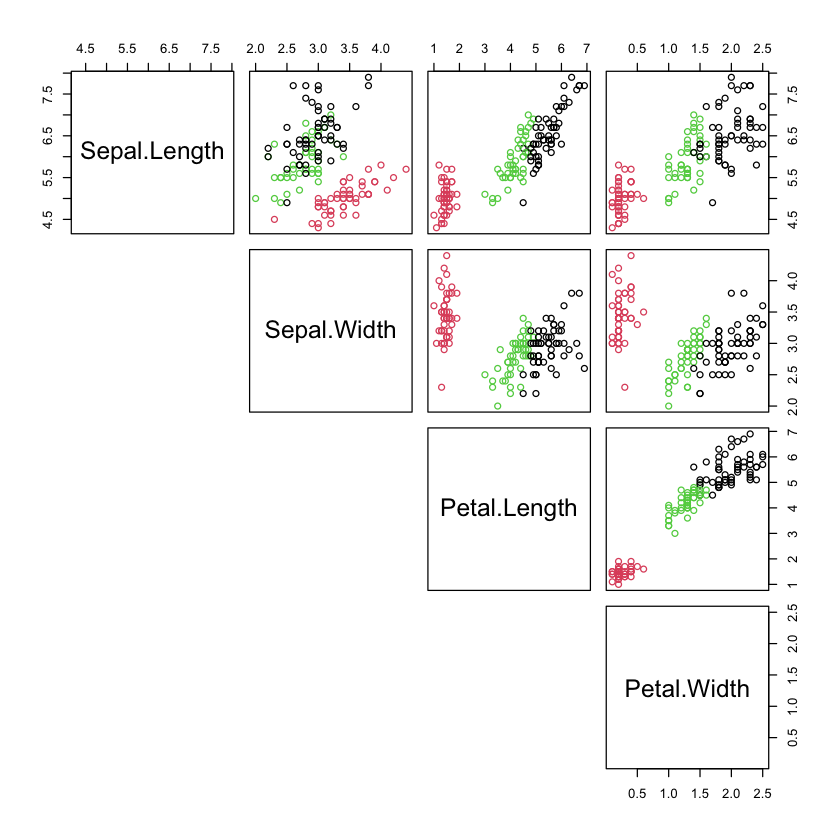

In [8]:
# YOUR CODE HERE



# SOLUTION
gmm1 <- gmm_manual(X, 3)
pairs(X, lower.panel = NULL, col = gmm1$cluster)
table(y, gmm1$cluster)

**EXERCISE 8:** Compare the results obtained by K-means and GMM. Which one provides the best results? _Hint:_ Calculate the accuracy.

YOUR ANSWER HERE


SOLUTION

GMM performs better with accuracy 96% versus 89%.

In [33]:
#kmeans ACC
(50+48+36)/nrow(X)
#gmm ACC
(50+50+45)/nrow(X)

[1] 0.8933333

[1] 0.9666667

Before moving to section 2 (next jupyter notebook), let us see how the previous function learned the clusters. The main difference with K-means is that the GMM hard decision boundaries can be elliptical. Notice that the model converges rapidly since we initiated the model parameters with the K-means result, which already did most of the job.

<img src="figs_notebook/fig_gmm_anim.gif">

### 1.4. References

* Jain (2010), Data clustering: 50 years beyond K-means, Pattern Recognition Letters